In [ ]:
pip install transformers

     |████████████████████████████████| 2.3MB 2.8MB/s 
     |████████████████████████████████| 901kB 20.6MB/s 
     |████████████████████████████████| 3.3MB 23.9MB/s 


In [ ]:
pip install gluonnlp

     |████████████████████████████████| 348kB 2.9MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595699 sha256=fe1e8385d82e4d736ea03c0598a1c4f792869490c29b560b4d64345c91c482f6
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp


In [ ]:
pip install mxnet

     |████████████████████████████████| 46.9MB 70kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import os
import tensorflow as tf
from transformers import TFGPT2Model

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import re

In [ ]:
#코랩 드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/MyDrive/nsmc

/content/gdrive/.shortcut-targets-by-id/1QFLvFG2lvBvQYlmGuqAk_smSHjtFdw-Y/nsmc


아레 실행 커멘드는 gpt_ckpt 폴더가 있지 않은 경우에만 실행해주세요.

In [ ]:
pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=c0fc25d6f47b3f47584de20604db6e569f6c70663743973152419d9c278f7d76
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import wget
import zipfile

wget.download('https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/releases/download/v1.0/gpt_ckpt.zip')

with zipfile.ZipFile('gpt_ckpt.zip') as z:
    z.extractall()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-357f7915bded>", line 7, in <module>
    z.extractall()
  File "/usr/lib/python3.7/zipfile.py", line 1631, in extractall
    path = os.getcwd()
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_

FileNotFoundError: ignored

In [ ]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

## 데이터 준비하기

In [ ]:
pip install sentencepiece

     |████████████████████████████████| 1.2MB 2.9MB/s 


In [ ]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.1
SENT_MAX_LEN = 39

DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = "./data_out/"

In [ ]:
# 데이터 전처리 준비

DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head()

print("Total # dataset: train - {}".format(len(train_data)))

Total # dataset: train - 149995


In [ ]:
# 텍스트 전처리

def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean

In [ ]:
# train_data = train_data[:50] # for test

train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['document', 'label']].values:
    train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]

    tokens = [vocab[vocab.bos_token]]  
    tokens += pad_sequences([train_tokenized_text], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    train_data_sents.append(tokens)
    train_data_labels.append(train_label)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

## 모델 학습

In [ ]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Classifier, self).__init__()
        
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

In [ ]:
BASE_MODEL_PATH = './gpt_ckpt'
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at ./gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model_name = "tf2_gpt2_naver_movie"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit(train_data_sents, train_data_labels, 
                        epochs=NUM_EPOCHS, 
                        batch_size=BATCH_SIZE,
                        validation_split=VALID_SPLIT, 
                        callbacks=[earlystop_callback, cp_callback])

./data_out/tf2_gpt2_naver_movie -- Folder already exists 

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To 

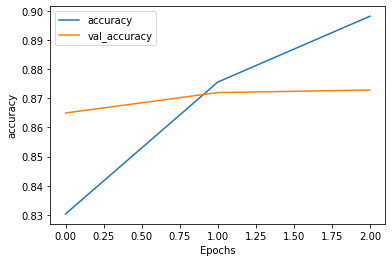

In [ ]:
plot_graphs(history, 'accuracy')

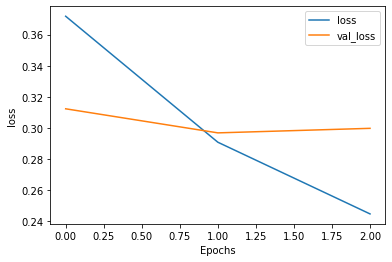

In [ ]:
plot_graphs(history, 'loss')

## 모델 테스트

In [ ]:
test_data = pd.read_csv(DATA_TEST_PATH, header=0, delimiter='\t', quoting=3)
test_data = test_data.dropna()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
# test_data = test_data[:50] # for test

test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['document','label']].values:
    test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]

    tokens = [vocab[vocab.bos_token]]  
    tokens += pad_sequences([test_tokenized_text], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    test_data_sents.append(tokens)
    test_data_labels.append(test_label)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [ ]:
print("num sents, labels {}, {}".format(len(test_data_sents), len(test_data_labels)))

num sents, labels 49997, 49997


In [ ]:
cls_model.load_weights(checkpoint_path)

results = cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

49/49 [==============================] - 241s 5s/step - loss: 0.3086 - accuracy: 0.8696
test loss, test acc:  [0.30860501527786255, 0.8695721626281738]


유튜브 영상 댓글 테스트셋

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/텍마팀플/채널모든댓글.csv',index_col=0)
data = data.drop(['topic'],axis=1)
data = data.drop(['token'],axis=1)
data["label"] = 1
data = data.dropna()
data.head()

,comments,label
0,헐 도안 굉장히 까다로우셨을 텐데 너무 이쁘게 잘 나온 것 같아요 역시 다정님 답습니다,1
1,다정하게 단순한 도안도 색 배치가 좋다면 더할 나위 없이 간결하고 예쁜 것 같아요 ...,1
2,꽃 할 때 후회했었어요 ㅎㅎㅎ 세밀하게 하는 게 힘들더라고요 다음번에는 좀 단순한...,1
3,대박터프팅러그란 말도 첨 들어보는 것 같아요 역시 손으로 하시는 건 다 잘하시는 것...,1
4,앗 홈데렐라에서 보셨군요 아직 재방송을 하나 보네요 ㅎㅎㅎ 반가워해 주셔서 감사합니다,1


In [ ]:
# test_data = test_data[:50] # for test

test_data_sents = []
test_data_labels = []

for test_sent, test_label in data[['comments','label']].values:
    try:
        test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]

        tokens = [vocab[vocab.bos_token]]  
        tokens += pad_sequences([test_tokenized_text], 
                                SENT_MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        test_data_sents.append(tokens)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [ ]:
cls_model.load_weights(checkpoint_path)

results = cls_model.predict(test_data_sents, batch_size=1024)

In [ ]:
logit = []
for i in results:
  logit.append(np.argmax(i))

In [ ]:
import collections, numpy
collections.Counter(logit)

Counter({0: 489, 1: 1901})

In [ ]:
# 부정(0)
for i, j in enumerate(logit):
    if j == 0:
        print(i, data['comments'][i])

11 진짜  금송이시다 전 러그는 사겠습니다 건에서 진동이 심하면 피로감을 많이 느끼실 수도 있어요 이미 느끼신 것 같지만
18 와 터프팅 러그 만드는 거 처음 봐요 엄청 잘하세요 금속
29 우와 입간판 저요 손들어봅니다 
30 다정하게 네 
31 아고 입간판은 처음 댓글 달아주신 분께 드리기로 했어요
46 그냥 뿌리를 쑥 심어 놓으면 마구 자라나요  물망초 궁금하네요 
49 입간판 저요
50 메일로 주소랑 연락처 성함 알려주시면 택배로 보내 드릴게요 
61 다정하게 지금 메일 드렸어요 감사합니다
71 다정하게 우와 너무 감사합니다
74 우와아 다정님 오늘도 영상 너무 감사히 잘 봤습니다 다정님 영상은 항상 행벅해요 구독자 이벤트라뇨 엉엉 도전해 볼 수 있어 감사합니다 몰디브 허니문 이탈리아 오사카 파리 방콕  영상에 나온 순으로 여행이 정답이요 ㅎㅎ평소에 엽서나 예쁜 그림으로 벽에 포인트를 주고 인테리어 하는 걸 좋아합니다 전 아직픗풋한 신혼이고 작년부터 강아지를 입양해 같이 살고 있어요 그러다 보니 사진 찍는 게 취미고 추억 남기기를 좋아해요 폴라로이드 같은 걸 가지고 싶었어요  만일 인스탁스에 당첨된다면 넘넘 행복할 것 같네요 임스 닥스로 다정님처럼 분위기나 기분에 따라 출력해서 예쁜 집을 꾸밀 수 있을 것 같아요 꼭 당첨 기도합니다 
75 커뮤니티 확인해 주시고 제 메일 주소로 메일 한 통만 부탁드릴게요  
81 몰디브 허니문 이탈리아 오사카 파리 방콕이와 엽서랑 사진이랑 같이 배치하다니 감각이 너무 좋으신데요 저도 텅 빈 방의 흰 벽을 추억으로 꾸미고 싶어요 아침에 눈뜨면 커튼 사이로 들어오는 햇볕과 사진의 조화 코로나 때문에 집콕으로 허한 마음을 달래줄 추억여행 원래 랜선 여행보다 추억여행이죠 다음 주에 친구들이랑 캠핑을 가는데 사진을 인화해서 나눠주고 싶어요
86 다정하게 우왕 감사해요 방금 메일 남겼어요
91 몰디브 이탈리아 오사카 파리 방콕입니다 와 연동이 너무 신기해서 엄청 집중해서 봤어요 저렇게 작고 편집도 가능하다니 너무너무 귀여워요 여행

In [ ]:
# 긍정(1)
for i, j in enumerate(logit):
    if j == 1:
        print(i, data['comments'][i])

0 헐 도안 굉장히 까다로우셨을 텐데 너무 이쁘게 잘 나온 것 같아요 역시 다정님 답습니다
1 다정하게 단순한 도안도 색 배치가 좋다면 더할 나위 없이 간결하고 예쁜 것 같아요 언제나 응원합니다
2 꽃 할 때 후회했었어요 ㅎㅎㅎ 세밀하게 하는 게 힘들더라고요  다음번에는 좀 단순한 도안으로 해볼까 생각 중이에요
3 대박터프팅러그란 말도 첨 들어보는 것 같아요 역시 손으로 하시는 건 다 잘하시는 것 같아요 부럽네요 근대 많이 어려워 보여요 인내심도 많이 필요할 것 같고ㅎ암튼 대단하시네요 나중엔 먼일 내실듯ㅎㅎ저 얼마 전에 홈에 랄라인가 인테리어 신혼집 소개하는 프로그램에서 다정님 나오는데 어찌나 반갑던지ㅎㅎ왠지 저의 지인이 나온 것처럼 정말 신기해하면서 봤습니다ㅎㅎ제가 생각해도 그때 제가 한 행동이 너무 웃겼어요ㅎㅎ
4 앗 홈데렐라에서 보셨군요  아직 재방송을 하나 보네요 ㅎㅎㅎ 반가워해 주셔서 감사합니다 
5 러그 기계 무거워 보이는데요 오래 들고 있으면 어깨 아픈가요 ㅠ 수고하셨어요
6 다정하게 이렇게 자세하고 친절히 알려주셔서 너무 감사해요 
7 다정하게 ㅠㅠ 저는 오랫동안 무거운 것 못 들어서 아무리  하고 싶어도 꾹 참고 있어요 ㅠ 언젠가는 가볍고 시끄럽지 아는 기계가 나오길 바라며 ㅠㅠ
8 어깨도 아프고 손도 아파요 ㅎㅎ 손에 굳은살이 바로 생기더라고요  첫날은 몸살도 한바탕 걸렸었어요 ㅎㅎ
9 역시 금속 다정님 저는 그냥 러그 살래 요금 손 다정님 덕분에 행복한 주말 보냈어요 이번 주도 파이팅 하세요 다정님
10 놀러 와주셔서 감사합니다  이번 주도 파이팅
12 맞아요 ㅎㅎ 그래서 첫날에 하고 와서 몸살 한바탕 걸리고 그다음에는 익숙해졌는지 아무렇지 않더라고요  너무 재미있어요
13 저도 터프팅러그 한번 해보고 싶었는데 다정님 하신 거 보니 더 해보고 싶네요 재밌어 보여요
14 정말 재미있어요 하면서 스트레스가 정말 풀려요
15 우와터프팅 금속이신 건 알았지만 감성 편집 실제보다 멋져 보이는 공방 감사합니다 
16 꽃 눈코입 만들면서 계속 긴가민가 

KeyError: ignored